In [11]:
import io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [23]:
src_path = 'data/wiki.multi.en.vec'
tgt_path_ru = 'data/wiki.multi.ru.vec'
tgt_path_ua = 'data/wiki.multi.uk.vec'
nmax = 100000  # maximum number of word embeddings to load

src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
tgt_embeddings_ru, tgt_id2word_ru, tgt_word2id_ru = load_vec(tgt_path_ru, nmax)
tgt_embeddings_ua, tgt_id2word_ua, tgt_word2id_ua = load_vec(tgt_path_ua, nmax)

# Check nearest neighbours

In [24]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

In [25]:
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, src_embeddings, src_id2word, K=5)

Nearest neighbors of "cat":
1.0000 - cat
0.7322 - cats
0.6453 - kitten
0.6381 - dog
0.6218 - kittens


In [26]:
src_word = 'deer'
get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings_ru, tgt_id2word_ru, K=5)

Nearest neighbors of "deer":
0.6002 - оленей
0.5844 - оленя
0.5742 - кабана
0.5693 - косули
0.5590 - олени


In [29]:
src_word = 'beautiful'
get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings_ua, tgt_id2word_ua, K=5)

Nearest neighbors of "beautiful":
0.6227 - красиві
0.6101 - красиве
0.6024 - прекрасні
0.6007 - прекрасний
0.5984 - прекрасної


# Visualize word vectors in shared space

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True) 
pca.fit(np.vstack([src_embeddings, tgt_embeddings_ru]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

Variance explained: 0.05


In [31]:
pca_ua = PCA(n_components=2, whiten=True) 
pca.fit(np.vstack([src_embeddings, tgt_embeddings_ua]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

Variance explained: 0.05


In [32]:
def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()

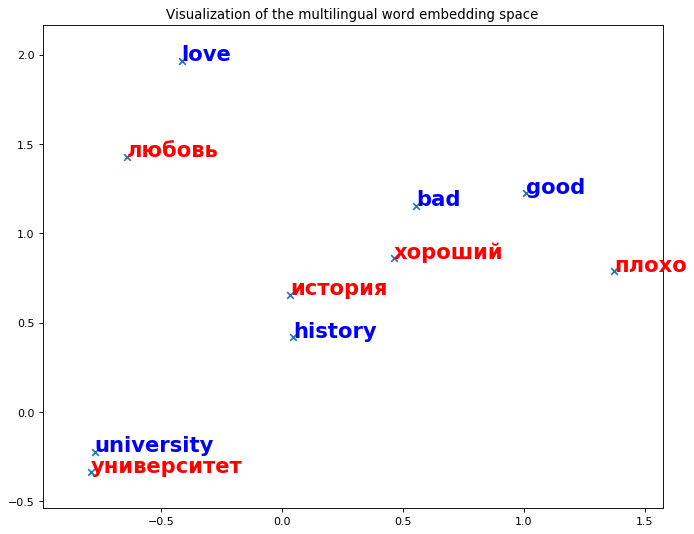

In [33]:
src_words = ['university', 'love', 'history', 'good', 'bad']
tgt_words_ru = [u'университет', u'любовь', u'история', u'хороший', u'плохо']


for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words_ru:
    assert tw in tgt_word2id_ru, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words_ru, tgt_word2id_ru, tgt_embeddings_ru, pca)

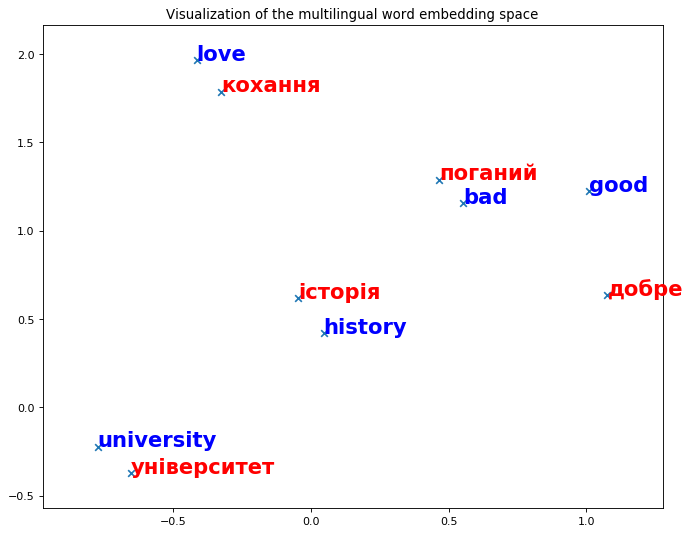

In [36]:
src_words = ['university', 'love', 'history', 'good', 'bad']
tgt_words_ua = [u'університет', u'кохання', u'історія', u'добре', u'поганий']

for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words_ua:
    assert tw in tgt_word2id_ua, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words_ua, tgt_word2id_ua, tgt_embeddings_ua, pca)